In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb

Training

In [13]:
df = pd.read_csv('LLCP2023_clean.csv', keep_default_na=False, dtype='category')

In [14]:
label_encoders = {}
for column in df.columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [15]:
X = df.drop(columns=['_MENT14D'])
y = df['_MENT14D']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=len(y.unique()),
    random_state=42
)

In [19]:
def train_model(model, X_train, X_test, y_train, y_test):
    print("Model training start...")

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True
    )

    print("\nTraining completed!")
    return model

In [20]:
def evaluate_model(model, X_test, y_test):

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovo')

    print("\nModel evaluation results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

    print("\nDetailed classification report:")
    print(classification_report(y_test, y_pred))

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }

In [21]:
trained_model = train_model(model, X_train, X_test, y_train, y_test)

Model training start...
[0]	validation_0-mlogloss:1.04466	validation_1-mlogloss:1.04487
[1]	validation_0-mlogloss:1.00019	validation_1-mlogloss:1.00029
[2]	validation_0-mlogloss:0.96065	validation_1-mlogloss:0.96084
[3]	validation_0-mlogloss:0.92680	validation_1-mlogloss:0.92724
[4]	validation_0-mlogloss:0.90318	validation_1-mlogloss:0.90378
[5]	validation_0-mlogloss:0.88339	validation_1-mlogloss:0.88411
[6]	validation_0-mlogloss:0.85984	validation_1-mlogloss:0.86087
[7]	validation_0-mlogloss:0.83910	validation_1-mlogloss:0.84020
[8]	validation_0-mlogloss:0.82045	validation_1-mlogloss:0.82173
[9]	validation_0-mlogloss:0.80498	validation_1-mlogloss:0.80652
[10]	validation_0-mlogloss:0.78993	validation_1-mlogloss:0.79169
[11]	validation_0-mlogloss:0.77642	validation_1-mlogloss:0.77843
[12]	validation_0-mlogloss:0.76453	validation_1-mlogloss:0.76691
[13]	validation_0-mlogloss:0.75445	validation_1-mlogloss:0.75700
[14]	validation_0-mlogloss:0.74496	validation_1-mlogloss:0.74787
[15]	valida

In [22]:
metrics = evaluate_model(trained_model, X_test, y_test)


Model evaluation results:
Accuracy: 0.7114
F1 Score (weighted): 0.7075
ROC AUC Score: 0.8688

Detailed classification report:
              precision    recall  f1-score   support

           0       0.72      0.74      0.73      7472
           1       0.68      0.53      0.59      3548
           2       0.71      0.80      0.75      5070

    accuracy                           0.71     16090
   macro avg       0.71      0.69      0.69     16090
weighted avg       0.71      0.71      0.71     16090



In [23]:
model_path = "model-weights/xgb_model.json"

model.save_model(model_path)
print(f"Model saved in {model_path}")

Model saved in model-weights/xgb_model.json


In [24]:
loaded_model = xgb.XGBClassifier()

loaded_model.load_model(model_path)
print("Model successfully loaded")


Model successfully loaded


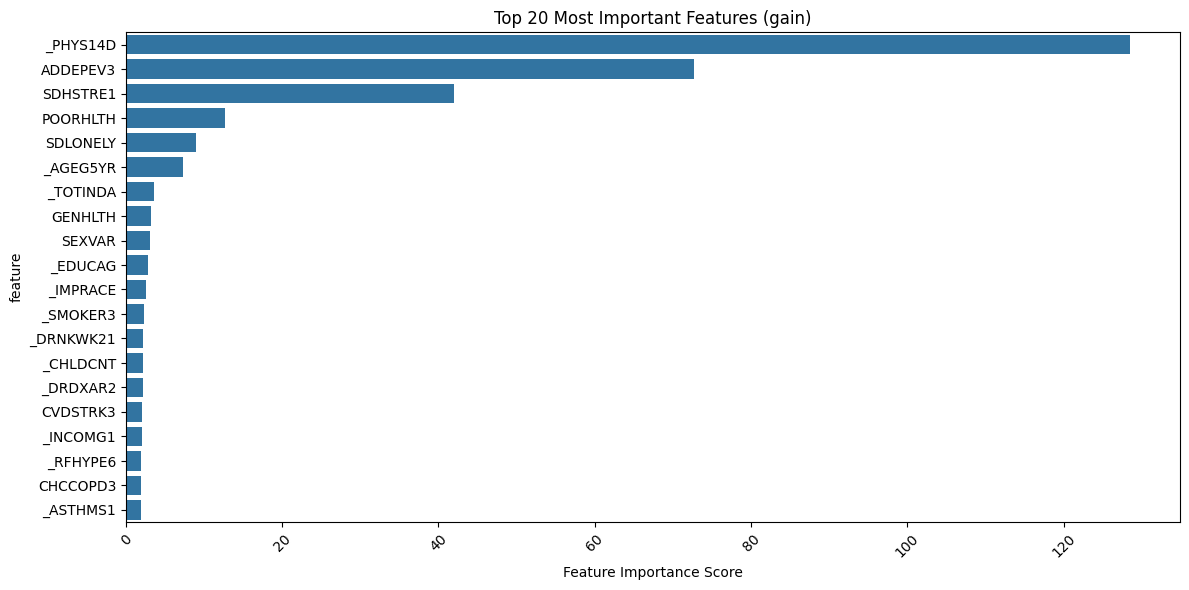

In [25]:
feature_importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
})
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(20), x='importance', y='feature')
plt.title('Top 20 Most Important Features (gain)')
plt.xlabel('Feature Importance Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()